In [6]:
import pickle
import numpy as np 
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt 

In [4]:
# %pip install xgboost

     |████████████████████████████████| 192.9 MB 18 kB/s              
You should consider upgrading via the '/home/adam/ENR_Sven/singularity/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [49]:
with open('../../data/processed/supervised_dataset_130522_v2.pickle', 'rb') as file: 
    supervised_dict = pickle.load(file) 
    
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
mp_cols = ['Q95', 'RGEO', 'CR0', 'VOLM', 'TRIU', 'TRIL', 'ELON', 'POHM', 'IPLA', 'BVAC', 'NBI', 'ICRH', 'ELER'] # supervised_dict['MP_ORDER']

In [8]:
def standardize(x, mu, var): 
    if mu is None and var is None: 
        mu = x.mean(0)
        var = x.std(0)
        x_normed = (x - mu ) / var
        return x_normed, mu, var
    else: 
        return (x - mu) / var
    
def standardize_mps(x, mu, var): 
    x_normed = np.copy(x)
    if mu is None and var is None: 
        mu = x[:, :-1].mean(0)
        var = x[:, :-1].std(0)
        x_normed[:, :-1] = (x[:, :-1] - mu ) / var
        return x_normed, mu, var
    else: 
        x_normed[:, :-1] = (x[:, :-1] - mu ) / var
        return x_normed
    
def de_standardize(x, mu, var): 
    return x*var + mu

In [50]:
# data_train, nesep_train = supervised_dict['train']['mps'], supervised_dict['train']['neseps_pulse']
# data_val, nesep_val = supervised_dict['val']['mps'], supervised_dict['val']['neseps_pulse']
# data_test, nesep_test = supervised_dict['test']['mps'], supervised_dict['test']['neseps_pulse']


data_train_all, nesep_train_all, elm_train, tseps_train = supervised_dict['train']['mps'], supervised_dict['train']['targets'], supervised_dict['train']['elms'], supervised_dict['train']['tseps']
data_val_all, nesep_val_all, elm_val, tseps_val = supervised_dict['val']['mps'], supervised_dict['val']['targets'], supervised_dict['val']['elms'], supervised_dict['val']['tseps']
data_test_all, nesep_test_all, elm_test, tseps_test = supervised_dict['test']['mps'], supervised_dict['test']['targets'], supervised_dict['test']['elms'], supervised_dict['test']['tseps']

data_train_all_norm,  MP_mu, MP_var = standardize_mps(data_train_all, None, None)
data_val_all_norm = standardize_mps(data_val_all,  MP_mu, MP_var)
data_test_all_norm = standardize_mps(data_test_all,  MP_mu, MP_var)

data_train_all_norm = np.column_stack((data_train_all_norm, 100*elm_train))
data_val_all_norm = np.column_stack((data_val_all_norm, 100*elm_val))
data_test_all_norm = np.column_stack((data_test_all_norm, 100*elm_test))

data_train_all_norm = np.column_stack((data_train_all_norm, tseps_train))
data_val_all_norm = np.column_stack((data_val_all_norm, tseps_val))
data_test_all_norm = np.column_stack((data_test_all_norm, tseps_test))
# data_train_all_norm[:, -1] = data_train_all_norm[:, -1]*100
# data_val_all_norm[:, -1] = data_val_all_norm[:, -1]*100
# data_test_all_norm[:, -1] = data_test_all_norm[:, -1]*100

nesep_train_all_norm, NSEP_mu, NSEP_var = standardize(nesep_train_all, None, None)
nesep_val_all_norm = standardize(nesep_val_all, NSEP_mu, NSEP_var)
nesep_test_all_norm = standardize(nesep_test_all, NSEP_mu, NSEP_var)

In [51]:
# data_train_all_without_nans[:, :-1].shape, data_train_all_without_nans.shape, data_train_all_norm.shape
data_train_all_norm[:, -1].max()

124.19180760146611

In [52]:
# normalize 

# dtrain = xgb.DMatrix(data_train_norm, nesep_train_norm)
# dval = xgb.DMatrix(data_val_norm, nesep_val_norm)
# dtest = xgb.DMatrix(data_test_norm, nesep_test_norm)
dtrain_all = xgb.DMatrix(data_train_all_norm, nesep_train_all_norm)
dval_all = xgb.DMatrix(data_val_all_norm, nesep_val_all_norm)
dtest_all = xgb.DMatrix(data_test_all_norm, nesep_test_all_norm)

# evallist = [(dtest, 'eval'), (dtrain, 'train')]
evallist_all = [(dval_all, 'eval'), (dtrain_all, 'train')]


[0]	eval-rmse:0.97536	train-rmse:0.98204
[1]	eval-rmse:0.87947	train-rmse:0.88520
[2]	eval-rmse:0.81663	train-rmse:0.82007
[3]	eval-rmse:0.77692	train-rmse:0.77818
[4]	eval-rmse:0.74723	train-rmse:0.74566


/home/adam/ENR_Sven/singularity/lib/python3.8/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[5]	eval-rmse:0.72803	train-rmse:0.72673
[6]	eval-rmse:0.71523	train-rmse:0.70927
[7]	eval-rmse:0.70307	train-rmse:0.69517
[8]	eval-rmse:0.69690	train-rmse:0.68297
[9]	eval-rmse:0.69162	train-rmse:0.67670
[10]	eval-rmse:0.68582	train-rmse:0.67072
[11]	eval-rmse:0.68347	train-rmse:0.66630
[12]	eval-rmse:0.68059	train-rmse:0.66041
[13]	eval-rmse:0.67879	train-rmse:0.65645
[14]	eval-rmse:0.67754	train-rmse:0.65408
[15]	eval-rmse:0.67515	train-rmse:0.65058
[16]	eval-rmse:0.67393	train-rmse:0.64745
[17]	eval-rmse:0.67432	train-rmse:0.64455
[18]	eval-rmse:0.67328	train-rmse:0.64294
[19]	eval-rmse:0.67189	train-rmse:0.64068
[20]	eval-rmse:0.67050	train-rmse:0.63940
[21]	eval-rmse:0.66999	train-rmse:0.63836
[22]	eval-rmse:0.66920	train-rmse:0.63618
[23]	eval-rmse:0.66833	train-rmse:0.63457
[24]	eval-rmse:0.66959	train-rmse:0.63349
[25]	eval-rmse:0.67009	train-rmse:0.63208
[26]	eval-rmse:0.66890	train-rmse:0.62915
[27]	eval-rmse:0.66862	train-rmse:0.62825
[28]	eval-rmse:0.66762	train-rmse:0.626

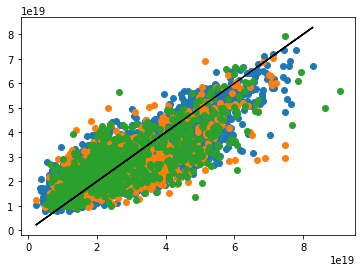

In [59]:
num_round = 100
param = {'max_depth': 3, 'eta': 0.25, 'gamma':0.00, 'objective': 'reg:squarederror'}
bst = xgb.train(param, dtrain_all, num_round, evallist_all)
# ypred_train = bst.predict(dtrain)
# ypred_val = bst.predict(dval)
# ypred_test = bst.predict(dtest)
ypred_train = de_standardize(bst.predict(dtrain_all), NSEP_mu, NSEP_var)
ypred_val = de_standardize(bst.predict(dval_all), NSEP_mu, NSEP_var)
ypred_test = de_standardize(bst.predict(dtest_all), NSEP_mu, NSEP_var)
plt.close('all')
plt.scatter(nesep_train_all, ypred_train)
plt.plot(nesep_train_all, nesep_train_all, color='black')
plt.scatter(nesep_val_all, ypred_val)
plt.scatter(nesep_test_all, ypred_test)

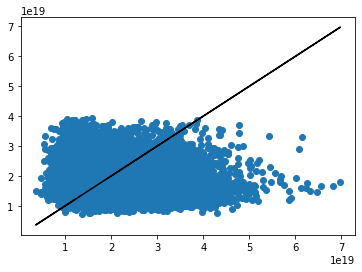

In [123]:
plt.close()


# ypred_all = bst.predict(dtrain_all) 
ypred_all = de_standardize(bst.predict(dtrain_all), NSEP_mu, NSEP_var)
plt.close('all')
plt.scatter(nesep_train_all, ypred_all)
plt.plot(nesep_train_all, nesep_train_all, color='black')


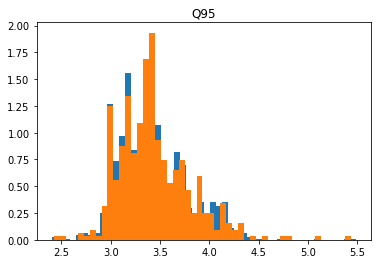

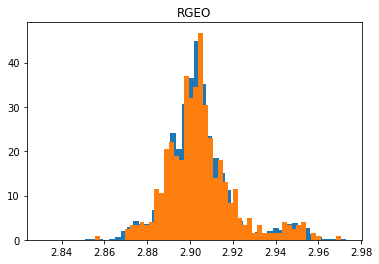

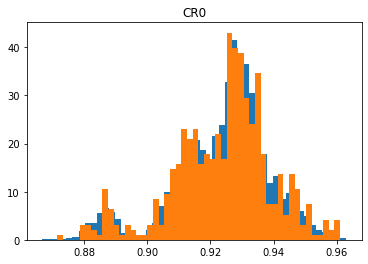

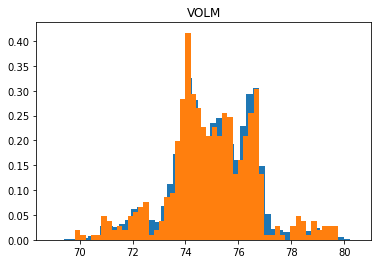

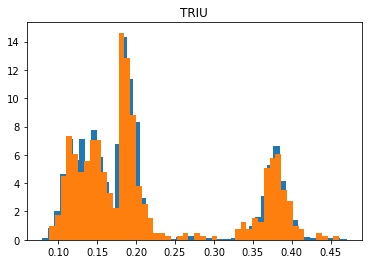

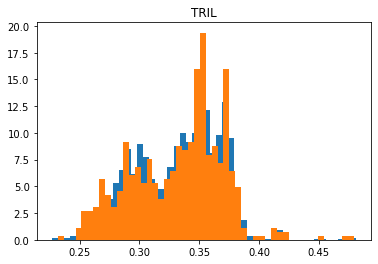

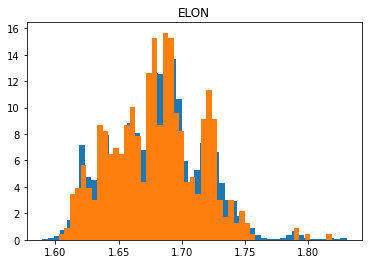

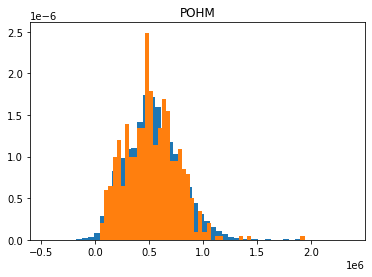

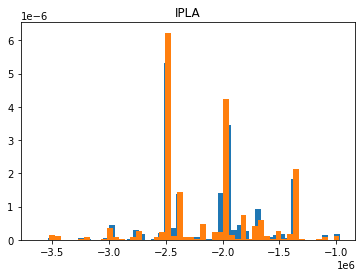

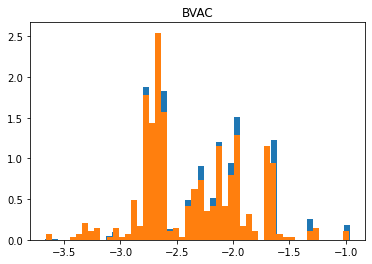

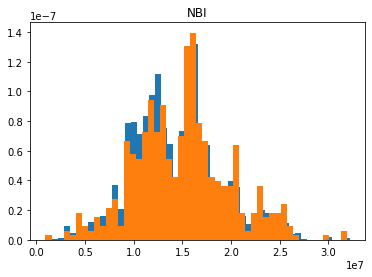

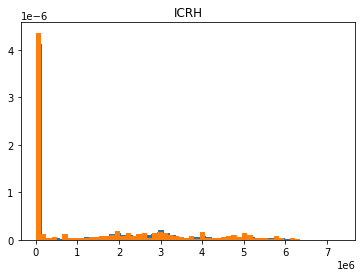

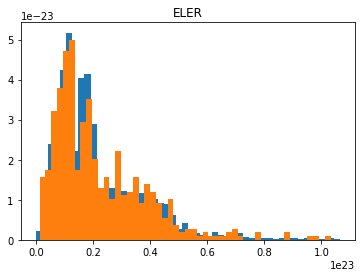

In [137]:
plt.close('all')
for k in range(len(data_train[0])): 
    plt.hist(data_train_all[:, k], density=True, bins=50)
    plt.hist(data_train[:, k], density=True, bins=50)
    plt.title(mp_cols[k])
    plt.show()

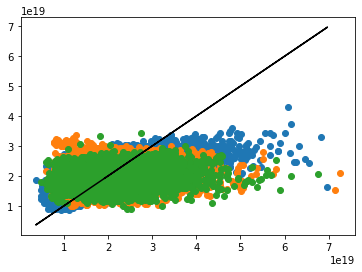